In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
import numpy as np
from bisect import bisect_left
import sys
import scipy.signal

sys.path.append('../../wdtools/')
#import wdtools

halpha = 6564
speed_light = 299792458
hbeta = 4861

plt.style.use('vedant')

In [2]:
rdata = np.sort(np.array(glob.glob('./d62_hch_reduced/*D62*r.fits')))
bdata = np.sort(np.array(glob.glob('./d62_hch_reduced/*D62*b.fits')))

In [3]:
## Load Models

Cfiles = np.sort(glob.glob('d62_models/*C*'))
Ofiles = np.sort(glob.glob('d62_models/*O*'))

Cdict = {};
Odict = {};

print(Ofiles)
print(Cfiles)

import csv

for filename in Cfiles:

    wl = [];
    fl = [];

    with open(filename, 'r') as fd:
        reader = csv.reader(fd)
        for ii,row in enumerate(reader):
            if ii == 0:
                pass
            if ii > 0 and 'Effective' not in row[0]:
                wl.extend(np.array(row[0].split()).astype(float))

            if 'Effective' in row[0]:
                break

        for jj,row in enumerate(reader):
            if jj <= ii:
                pass

            fl.extend(np.array(row[0].split()).astype(float))
        
        abundance = filename.split('_')[-1]
        Cdict[abundance] = np.array(fl)

for filename in Ofiles:

    wl = [];
    fl = [];

    with open(filename, 'r') as fd:
        reader = csv.reader(fd)
        for ii,row in enumerate(reader):
            if ii == 0:
                pass
            if ii > 0 and 'Effective' not in row[0]:
                wl.extend(np.array(row[0].split()).astype(float))

            if 'Effective' in row[0]:
                break

        for jj,row in enumerate(reader):
            if jj <= ii:
                pass

            fl.extend(np.array(row[0].split()).astype(float))
        
        abundance = filename.split('_')[-1]
        Odict[abundance] = np.array(fl)

['d62_models/541074.2hepu_g15.2_O_0.0'
 'd62_models/541074.2hepu_g15.2_O_0.5'
 'd62_models/541074.2hepu_g15.2_O_1.0'
 'd62_models/541074.2hepu_g15.2_O_1.5'
 'd62_models/541074.2hepu_g15.2_O_2.0'
 'd62_models/541074.2hepu_g15.2_O_2.5'
 'd62_models/541074.2hepu_g15.2_O_3.0'
 'd62_models/541074.2hepu_g15.2_O_4.0'
 'd62_models/541074.2hepu_g15.2_O_5.0']
['d62_models/541074.2hepu_g15.2_C_3.0'
 'd62_models/541074.2hepu_g15.2_C_4.0'
 'd62_models/541074.2hepu_g15.2_C_5.0'
 'd62_models/541074.2hepu_g15.2_C_6.0'
 'd62_models/541074.2hepu_g15.2_C_7.0'
 'd62_models/541074.2hepu_g15.2_C_8.0'
 'd62_models/541074.2hepu_g15.2_C_9.0']


In [4]:
Odict

{'0.0': array([1.0904e-05, 1.0905e-05, 1.0906e-05, ..., 1.6130e-05, 1.6130e-05,
        1.6130e-05]),
 '0.5': array([1.0900e-05, 1.0901e-05, 1.0902e-05, ..., 1.5988e-05, 1.5988e-05,
        1.5988e-05]),
 '1.0': array([1.0874e-05, 1.0875e-05, 1.0875e-05, ..., 1.5894e-05, 1.5894e-05,
        1.5894e-05]),
 '1.5': array([1.0848e-05, 1.0848e-05, 1.0849e-05, ..., 1.5828e-05, 1.5828e-05,
        1.5828e-05]),
 '2.0': array([1.0834e-05, 1.0835e-05, 1.0836e-05, ..., 1.5818e-05, 1.5818e-05,
        1.5817e-05]),
 '2.5': array([1.0835e-05, 1.0836e-05, 1.0836e-05, ..., 1.5841e-05, 1.5841e-05,
        1.5841e-05]),
 '3.0': array([1.0851e-05, 1.0851e-05, 1.0852e-05, ..., 1.5888e-05, 1.5888e-05,
        1.5888e-05]),
 '4.0': array([1.0930e-05, 1.0931e-05, 1.0931e-05, ..., 1.6067e-05, 1.6067e-05,
        1.6067e-05]),
 '5.0': array([1.1048e-05, 1.1048e-05, 1.1049e-05, ..., 1.6490e-05, 1.6490e-05,
        1.6489e-05])}

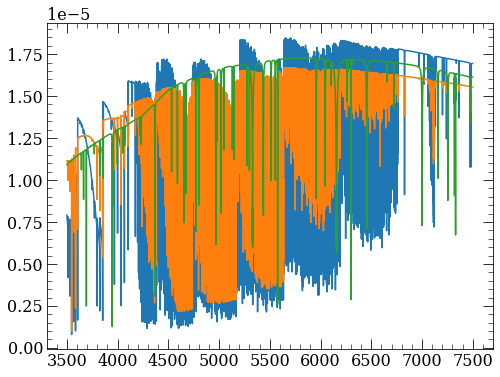

In [5]:
plt.plot(wl, Cdict['3.0']);
plt.plot(wl, Cdict['4.0'])
plt.plot(wl, Odict['0.0'])

In [6]:
modwl = np.array(wl) + 1.4 # Shift models to air wavelengths

In [7]:
def cont_norm(wl, fl, centre, window, edge):
    c1 = bisect_left(wl, centre - window)
    c2 = bisect_left(wl, centre + window)
    wl, fl = wl[c1:c2], fl[c1:c2]
    
    mask = np.ones(len(wl))
    mask[edge:-edge] = 0
    mask = mask.astype(bool)

    p = np.polynomial.polynomial.polyfit(wl[mask], fl[mask], 1)
    continuum = np.polynomial.polynomial.polyval(wl, p)
    norm_fl = fl / continuum
    return wl, norm_fl

In [8]:
import copy

Text(0.5, 0, 'Wavelength ($\\AA$)')

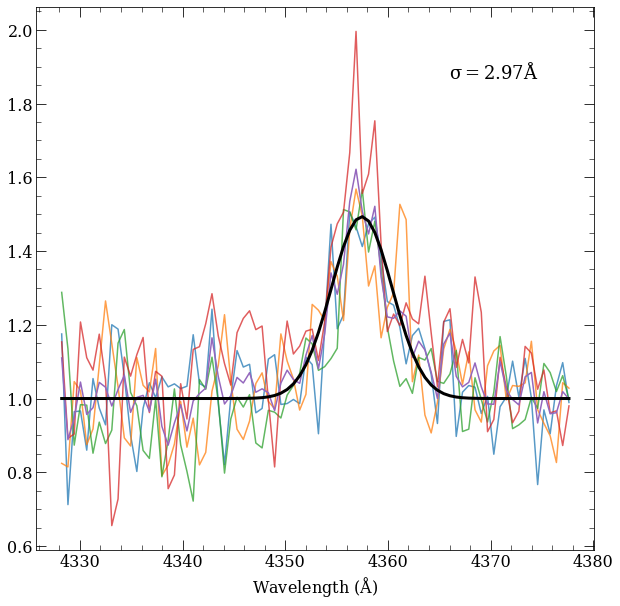

In [9]:
fig = plt.figure(figsize = (10, 10))

sumline = [];

for ii,filename in enumerate(bdata[2:]):
    with fits.open(filename) as f:
        wl = f[0].header['CRVAL1'] + f[0].header['CD1_1'] * np.arange(f[0].data.shape[2])
        fl = f[0].data[2][0]
        
        wl, fl = cont_norm(wl, fl, 4353, 25, 10)
        
        plt.plot(wl, fl, alpha = 0.75)
        
        #plt.xlim(6295, 6305)
        sumline.append(fl)
        
sumline = np.mean(sumline, 0)
y = sumline
x = wl

def gaus(x,a,x0,sigma):
    return 1 + a*np.exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = scipy.optimize.curve_fit(gaus,x,y,p0=[2,4357,0.5])

blue_sig = copy.deepcopy(popt[2])

plt.plot(x, y)
plt.plot(x, gaus(x, *popt), color = 'k', lw = 3)
plt.text(0.9, 0.9, r'$\sigma = %.2f \AA$' % popt[2], transform = plt.gca().transAxes, ha = 'right', va = 'top',
        fontsize = 18)
plt.xlabel('Wavelength ($\AA$)')

In [10]:
popt[2]

2.9656346766501955

Text(0.5, 0, 'Wavelength ($\\AA$)')

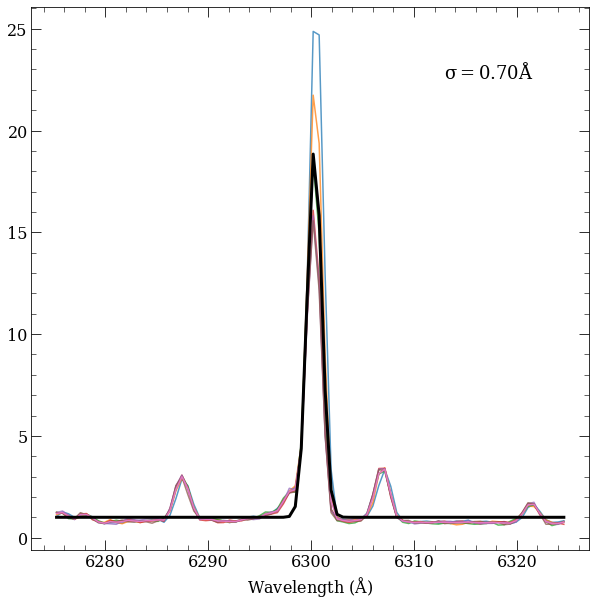

In [11]:
fig = plt.figure(figsize = (10, 10))

sumline = [];

for ii,filename in enumerate(rdata):
    with fits.open(filename) as f:
        wl = f[0].header['CRVAL1'] + f[0].header['CD1_1'] * np.arange(f[0].data.shape[2])
        fl = f[0].data[2][0]
        
        wl, fl = cont_norm(wl, fl, 6300, 25, 10)
        
        plt.plot(wl, fl, alpha = 0.75)
        
        #plt.xlim(6295, 6305)
        sumline.append(fl)
        
sumline = np.mean(sumline, 0)
y = sumline
x = wl

def gaus(x,a,x0,sigma):
    return 1 + a*np.exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = scipy.optimize.curve_fit(gaus,x,y,p0=[2,6300,0.5])

red_sig = popt[2]

plt.plot(x, y)
plt.plot(x, gaus(x, *popt), color = 'k', lw = 3)
plt.text(0.9, 0.9, r'$\sigma = %.2f \AA$' % popt[2], transform = plt.gca().transAxes, ha = 'right', va = 'top',
        fontsize = 18)

plt.xlabel('Wavelength ($\AA$)')

In [12]:
popt[2]

0.7038026216637117

In [13]:
6300 / (popt[2] * 2.35)

3809.0950236765975

In [14]:
blue_sig, red_sig

(2.9656346766501955, 0.7038026216637117)

In [15]:
start = 0

blue_fl = [];

for ii,filename in enumerate(bdata[start:]):
    with fits.open(filename) as f:
        blue_wl = f[0].header['CRVAL1'] + f[0].header['CD1_1'] * np.arange(f[0].data.shape[2])
        fl = f[0].data[1][0]
        blue_fl.append(fl)

blue_fl = np.mean(blue_fl, 0)
blue_fl = blue_fl * blue_wl**2 / (2.9979e-5)


red_fl = [];

for ii,filename in enumerate(rdata[start:]):
    with fits.open(filename) as f:
        red_wl = f[0].header['CRVAL1'] + f[0].header['CD1_1'] * np.arange(f[0].data.shape[2])
        fl = f[0].data[1][0]
        
        red_fl.append(fl)

red_fl = np.mean(red_fl, 0)

red_fl = red_fl * red_wl**2 / (2.9979e-5)

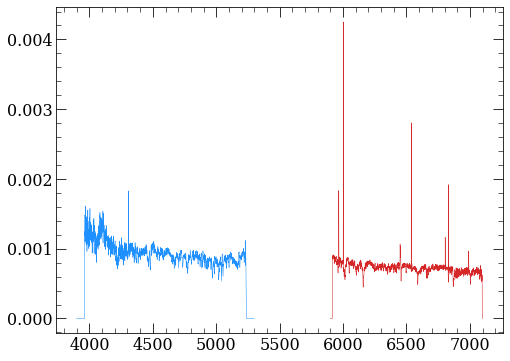

In [16]:
plt.plot(blue_wl, blue_fl, color = 'dodgerblue', lw = 0.5)
plt.plot(red_wl, red_fl, color = 'tab:red', lw = 0.5)

In [17]:
wl = np.concatenate((blue_wl, red_wl))
fl = np.concatenate((blue_fl, red_fl))

In [18]:
spec = np.vstack((wl, fl)).T

In [19]:
np.savetxt('d62_apo.txt', spec)

## Analyze

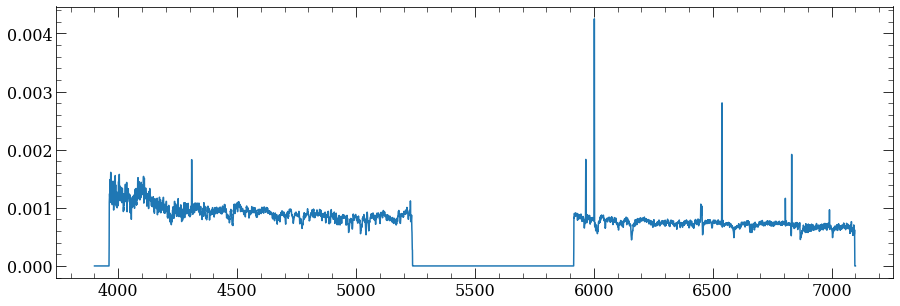

In [20]:
plt.figure(figsize = (15, 5))

plt.plot(wl, fl)

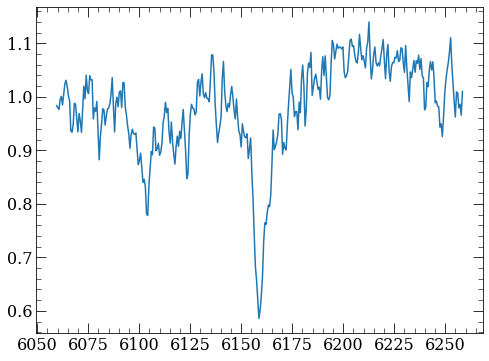

In [21]:
cwl, cfl = cont_norm(wl, fl, 6159, 100, 10)
plt.plot(cwl, cfl)

In [29]:
linelist = {
    
    'C' : [5041, 6013, 5151, 4462, 6591, 6828],
    'O' : [6158, 6455, 4775, 7002],
    'Ca' : [4226, 5019],
    'Mg' : [4860, 4483],
    #'?' : [4972, 6871],
    'circum': [4462,6591, 5041, 6013, 6828]
    
}

cdict = {
    
    'C' : 'red',
    'O' : 'dodgerblue',
    'Ca' : 'C1',
    'Mg' : 'C4',
    #'?' : 'C5',    
}



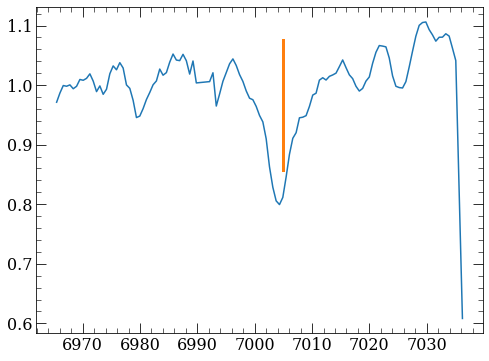

In [30]:
line = 7005

cwl, cfl = cont_norm(wl, fl, line, 40, 10)
plt.plot(cwl, cfl)
plt.axvline(line, ymin = 0.5, ymax = 0.9, color = 'C1', lw = 3)

#plt.ylim(0.4, 1.5)

In [31]:
def vac_to_air(wl):
    air_wl = wl / (1.0 + 2.735182E-4 + 131.4182 / wl**2 + 2.76249E8 / wl**4)
    return air_wl

### Plot spectrum and models

In [32]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [33]:
from numpy.polynomial.polynomial import polyfit, polyval

In [34]:
def polynorm(wl, fl):
    p = polyfit(wl, fl, 2)
    cont = polyval(wl, p)
    fl = fl / cont
    return wl, fl

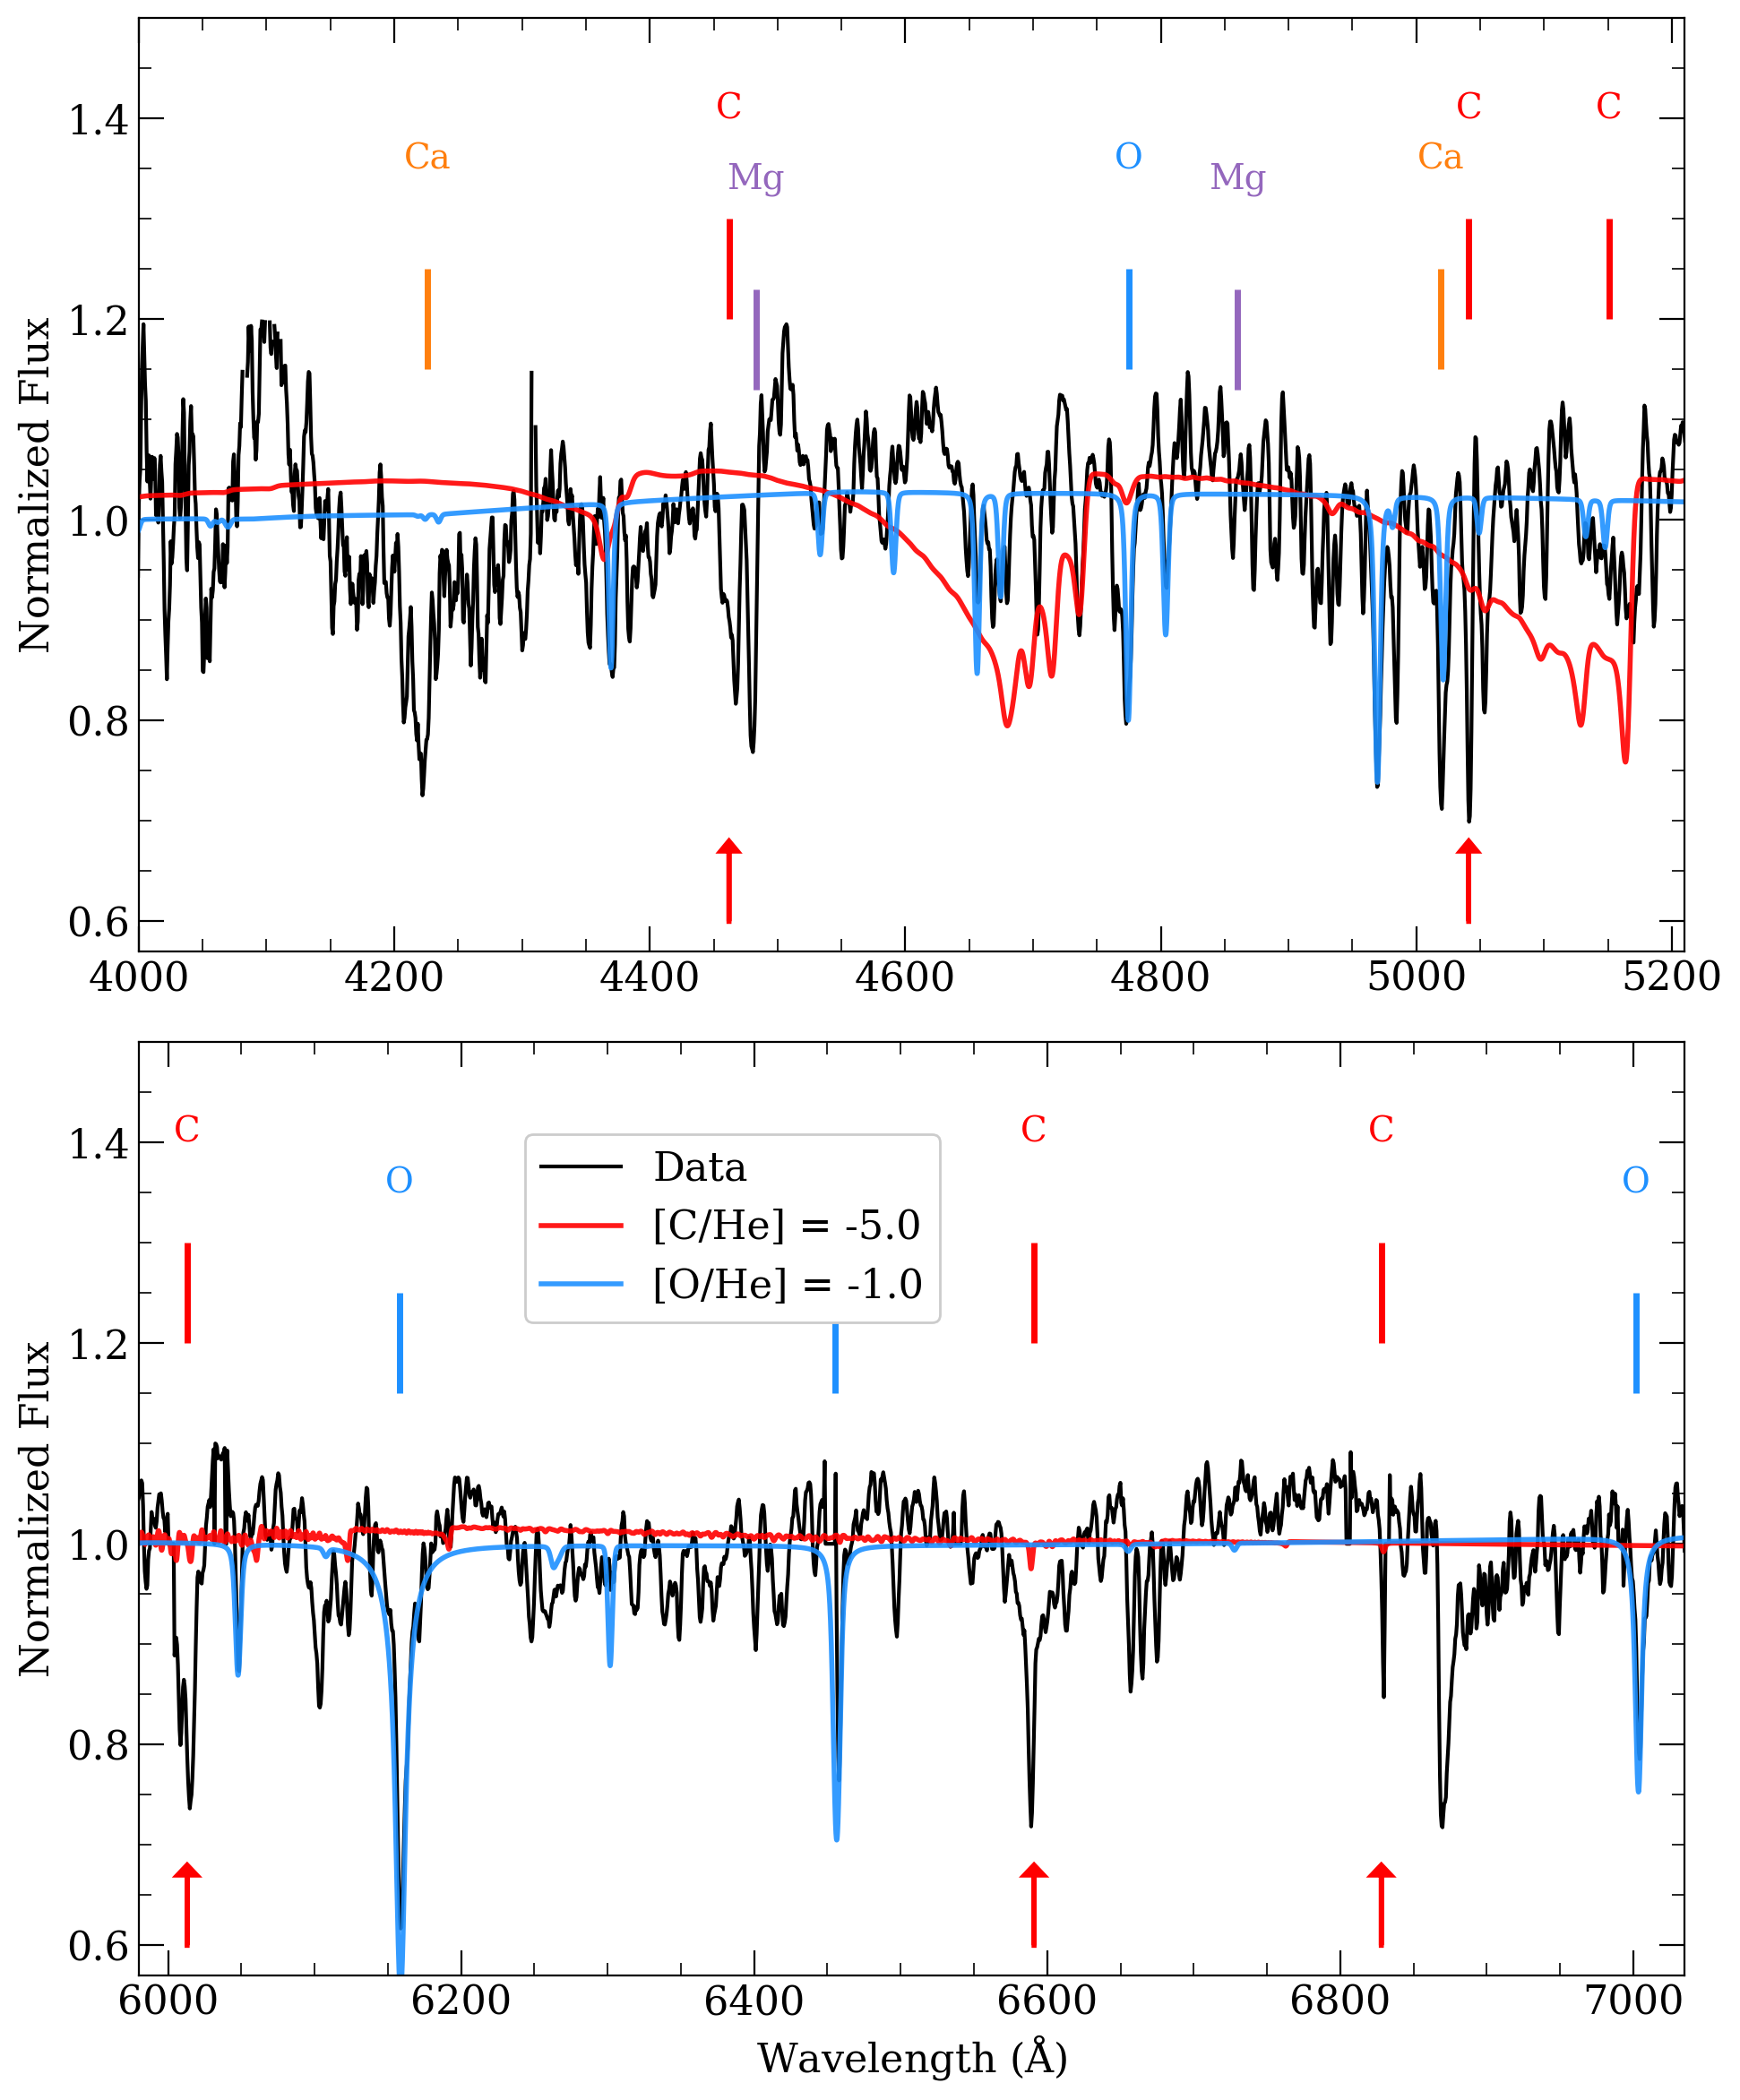

In [40]:
plt.figure(figsize = (10, 12), dpi = 200)

lw = 1.5
mlw = 2

plt.subplot(211)

wl = blue_wl[115:-110]
fl = blue_fl[115:-110]
wl,fl = polynorm(wl, fl)
fl = smooth(fl, 5)
fl[fl > 1.2] = np.nan

plt.plot(wl, fl, 'k', lw = lw, label = 'Data')

modfl = Cdict['5.0']
modfl = scipy.ndimage.gaussian_filter1d(modfl, blue_sig / np.median(np.diff(modwl)))
modwl, modfl = polynorm(modwl, modfl)
modfl = smooth(modfl, 5)
plt.plot(modwl, modfl, 'red', lw = mlw, label = '[C/H] = -5.0', alpha = 0.9)

modfl = Odict['1.0']
modfl = scipy.ndimage.gaussian_filter1d(modfl, blue_sig/ 2 / np.median(np.diff(modwl)))
modwl, modfl = polynorm(modwl, modfl)
modfl = smooth(modfl, 5)
plt.plot(modwl, modfl, 'dodgerblue', lw = mlw, label = '[O/H] = -1.0', linestyle = '-', alpha = 0.9)


for key,lines in linelist.items():
    for line in lines:
        if line > 5200:
            continue
            
        if key == 'C':
            offset = 0.05
        elif key == 'Mg':
            offset = -0.02
        elif key == 'circum':
            #plt.vlines(line, ymin = 0.6, ymax = 0.68, lw = 3, color = 'red')
            plt.arrow(line, 0.6, 0, 0.07,  color = 'red', head_width = 13,
                     head_length = 0.01, linewidth = 2)
            continue
        else:
            offset = 0
        plt.vlines(line, ymin = 1.15 + offset, ymax = 1.25 + offset, lw = 2.5, color = cdict[key])
        plt.text(line, 1.35 + offset, key, ha = 'center', fontsize = 14, color = cdict[key])

plt.xlim(4000, 5210)
plt.ylim(0.57, 1.5)
plt.ylabel('Normalized Flux')

plt.subplot(212)

wl = red_wl[115:-110]
fl = red_fl[115:-110]
wl,fl = polynorm(wl, fl)
fl = smooth(fl, 5)
fl[fl > 1.1] = 1

plt.plot(wl, fl, 'k', lw = lw, label = 'Data')

modfl = Cdict['5.0']
modfl = scipy.ndimage.gaussian_filter1d(modfl, red_sig / np.median(np.diff(modwl)))
modwl, modfl = polynorm(modwl, modfl)
modfl = smooth(modfl, 5)
plt.plot(modwl, modfl, 'red', lw = mlw, label = '[C/He] = -5.0', alpha = 0.9)

# modfl = Cdict['4.0']
# modfl = scipy.ndimage.gaussian_filter1d(modfl, red_sig / np.median(np.diff(modwl)))
# modwl, modfl = polynorm(modwl, modfl)
# modfl = smooth(modfl, 5)
# plt.plot(modwl, modfl, 'red', lw = 1, label = '[C/He] = -4.0', alpha = 0.5, linestyle = '--')

modfl = Odict['1.0']
modfl = scipy.ndimage.gaussian_filter1d(modfl, red_sig*2 / np.median(np.diff(modwl)))
modwl, modfl = polynorm(modwl, modfl)
modfl = smooth(modfl, 5)
plt.plot(modwl, modfl, 'dodgerblue', lw = mlw, label = '[O/He] = -1.0', linestyle = '-', alpha = 0.9)


for key,lines in linelist.items():
    for line in lines:
        if line < 5200:
            continue
            
        if key == 'C':
            offset = 0.05
        elif key == 'circum':
            #plt.vlines(line, ymin = 0.6, ymax = 0.68, lw = 3, color = 'red')
            plt.arrow(line, 0.6, 0, 0.07,  color = 'red', head_width = 13,
                     head_length = 0.01, linewidth = 2)
            continue
        else:
            offset = 0
        plt.vlines(line, ymin = 1.15 + offset, ymax = 1.25 + offset, lw = 2.5, color = cdict[key])
        plt.text(line, 1.35 + offset, key, ha = 'center', fontsize = 14, color = cdict[key])

plt.xlim(5980, 7035)
plt.ylim(0.57, 1.5)
plt.legend(loc = (0.25, 0.7), framealpha = 1, fontsize = 16)
plt.ylabel('Normalized Flux')
plt.xlabel('Wavelength ($\AA$)')

plt.tight_layout()

plt.savefig('fig/d62_apo.pdf', bbox_inches = 'tight', dpi = 300)

### Get Rough RV

In [42]:
wl = red_wl[115:-110]
fl = red_fl[115:-110]


line = 7002.23

wl,fl = cont_norm(wl, fl, line, 10, 5)

In [43]:
def gaus(x,a,x0,sigma):
    return 1 - a*np.exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = scipy.optimize.curve_fit(gaus,wl,fl,p0=[2,line,0.5])

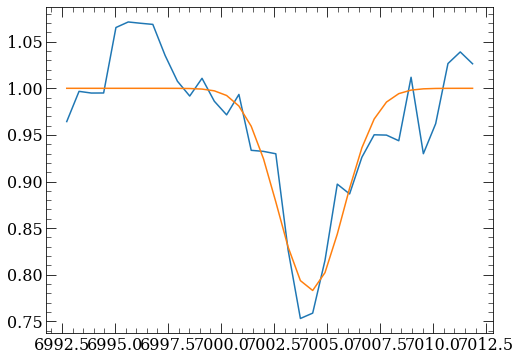

In [44]:
plt.plot(wl, fl)
plt.plot(wl, gaus(wl, *popt))

In [45]:
centre = popt[1]
e_centre = np.sqrt(pcov[1,1])

In [46]:
rv = 3e5 * (centre - line)/line
e_rv = 3e5 * (e_centre)/line

In [47]:
rv, e_rv

(85.84000295472563, 7.516695616403683)

In [48]:
blue_sig

2.9656346766501955

In [49]:
red_sig

0.7038026216637117